In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-5", temperature=0)

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

LANGSMITH_API_KEY:  ········


In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Doctor(BaseModel):
    name: str = Field(
        description="Name of the doctor."
    )
    qualifications: str = Field(
        description="Qualifications of the doctor",
    )
    specialization: str = Field(
        description="Specialization of the dcotor i.e., cardiologist, dermatologist, orthopedist, etc.",
    )
    experience: int = Field(
        description="Number of years of work experience of the doctor"
    )
    description: str = Field(
        description="Description of the doctor's place of work, achievements, etc.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nQualifications: {self.qualifications}\nSpecialization: {self.specialization}\nExperience: {self.experience}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    doctors: List[Doctor] = Field(
        description="Comprehensive list of doctors with their specializations, place of work and qualifications.",
    )

class GenerateDoctorsState(TypedDict):
    symptom: str 
    max_doctors: int 
    human_feedback: str 
    doctors: List[Doctor]

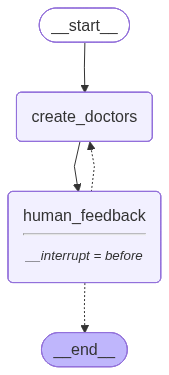

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

doctor_instructions="""You are tasked with creating a set of Doctors. Follow these instructions carefully:

1. First, take a look at the symptom: {symptom}
        
2. Examine any feedback that has been optionally provided to guide creation of the doctor personas: 
        
{human_feedback}
    
3. Determine the most suitable specialists who can diagnose the symptom {symptom}.
                    
4. Pick the top {max_doctors} specialists most suited for the symptom {symptom}.

5. Assign one doctor for each specialization."""

def create_doctors(state: GenerateDoctorsState):
    
    """ Create doctors """
    
    symptom=state['symptom']
    max_doctors=state['max_doctors']
    human_feedback=state.get('human_feedback', '')
        
    structured_llm = llm.with_structured_output(Perspectives)

    system_message = doctor_instructions.format(symptom=symptom,
                                                            human_feedback=human_feedback, 
                                                            max_doctors=max_doctors)
 
    doctors = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the list of doctors.")])


    return {"doctors": doctors.doctors}

def human_feedback(state: GenerateDoctorsState):
    """ No-op node that should be interrupted on """
    pass



def should_continue(state):
    messages = state.get("messages", [])
    if not messages:
        # No messages yet, decide default behavior
        return END  # or "create_doctors" if you want to loop
    last_message = messages[-1].get("content", "").lower()
    if "thank you" in last_message:
        return END
    elif len(messages) >= state.get("max_num_turns", 15):
        return END
    else:
        return "create_doctors"
 
builder = StateGraph(GenerateDoctorsState)
builder.add_node("create_doctors", create_doctors)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_doctors")
builder.add_edge("create_doctors", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_doctors", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Creating a list of doctors
max_doctors = 3 
symptom = "I am having a pain in my lungs"
thread = {"configurable": {"thread_id": "1"}}
doctors=()
for event in graph.stream({"symptom":symptom,"max_doctors":max_doctors,}, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)  

Name: Dr. Aisha Rahman
Experience(in years): 16
Qualification: MD, FCCP (Pulmonary & Critical Care Medicine)
Specialization: Pulmonologist
Description: Board-certified pulmonologist at River Valley Medical Center focusing on pleuritic chest pain, pulmonary embolism, pneumonia, and asthma/COPD. Leads a multidisciplinary chest clinic and has authored peer-reviewed research on chest pain evaluation and lung imaging pathways.
--------------------------------------------------
Name: Dr. Miguel Alvarez
Experience(in years): 14
Qualification: MD, FACEP
Specialization: Emergency Medicine Physician
Description: Attending emergency physician at Metro City Medical Center. Specializes in rapid assessment of acute chest and lung pain, including pneumothorax, pulmonary embolism, and rib/thoracic injuries. Expert in bedside ultrasound and evidence-based chest pain/shortness-of-breath protocols.
--------------------------------------------------
Name: Dr. Priya Desai
Experience(in years): 18
Qualifica

In [7]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [8]:
graph.update_state(thread, {"human_feedback": 
                            "Add a Lung cancer specialist"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cf69f-838d-6b8e-8002-7e82919cbaa3'}}

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    doctors = event.get('doctors', '')
    if doctors:
        for doctor in doctors:
            print(f"Name: {doctor.name}")
            print(f"Experience(in years): {doctor.experience}")
            print(f"Qualification: {doctor.qualifications}")
            print(f"Specialization: {doctor.specialization}")
            print(f"Description: {doctor.description}")
            print("-" * 50)

Name: Dr. Aisha Rahman
Experience(in years): 16
Qualification: MD, FCCP (Pulmonary & Critical Care Medicine)
Specialization: Pulmonologist
Description: Board-certified pulmonologist at River Valley Medical Center focusing on pleuritic chest pain, pulmonary embolism, pneumonia, and asthma/COPD. Leads a multidisciplinary chest clinic and has authored peer-reviewed research on chest pain evaluation and lung imaging pathways.
--------------------------------------------------
Name: Dr. Miguel Alvarez
Experience(in years): 14
Qualification: MD, FACEP
Specialization: Emergency Medicine Physician
Description: Attending emergency physician at Metro City Medical Center. Specializes in rapid assessment of acute chest and lung pain, including pneumothorax, pulmonary embolism, and rib/thoracic injuries. Expert in bedside ultrasound and evidence-based chest pain/shortness-of-breath protocols.
--------------------------------------------------
Name: Dr. Priya Desai
Experience(in years): 18
Qualifica

In [10]:
further_feedack = None
graph.update_state(thread, {"human_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0cf69f-83bf-6e58-8003-d020ea2f4b4a'}}

In [11]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [12]:
final_state = graph.get_state(thread)
doctors = final_state.values.get('doctors')

In [13]:
final_state.next

()

In [14]:
for doctor in doctors:
    print(f"Name: {doctor.name}")
    print(f"Experience(in years): {doctor.experience}")
    print(f"Qualification: {doctor.qualifications}")
    print(f"Specialization: {doctor.specialization}")
    print(f"Description: {doctor.description}")
    print("-" * 50) 

Name: Dr. Aisha Rahman
Experience(in years): 16
Qualification: MD, FCCP (Pulmonary & Critical Care Medicine)
Specialization: Pulmonologist
Description: Board-certified pulmonologist at River Valley Medical Center focusing on pleuritic chest pain, pulmonary embolism, pneumonia, and asthma/COPD. Leads a multidisciplinary chest clinic and has authored peer-reviewed research on chest pain evaluation and lung imaging pathways.
--------------------------------------------------
Name: Dr. Miguel Alvarez
Experience(in years): 14
Qualification: MD, FACEP
Specialization: Emergency Medicine Physician
Description: Attending emergency physician at Metro City Medical Center. Specializes in rapid assessment of acute chest and lung pain, including pneumothorax, pulmonary embolism, and rib/thoracic injuries. Expert in bedside ultrasound and evidence-based chest pain/shortness-of-breath protocols.
--------------------------------------------------
Name: Dr. Priya Desai
Experience(in years): 18
Qualifica

In [15]:
# planning on arriving at result with the help of debates between the professionals.
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class DebateState(MessagesState):
    max_num_turns: int 
    context: Annotated[list, operator.add] 
    doctors: list
    debate: str 
    sections: list 

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [16]:
debate_instructions = """You are to initiate a discussion between multiple doctors to diagnose the given symptom. 

Your goal is to get all of them to justify their approach and try to convince the other doctors why their way is the best. Be open to all ideas and decide the best way.

1. Take turns: Have a back and forth with the other specialists on how to diagnose and treat the symptom.
        
2. Specific: Insights that avoid generalities and include specific knowledge from each induviduals field.

Here is your topic of focus and set of goals for each doctor: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then make your case.

Continue to ask questions to drill down and refine your treatment plan for the patient.

You are to make judgments based on just the symptoms of the patient, if there is any uncertainty (i.e. gender, age, history), you are to provide answers for all cases to be as all-encompassing as possible
        
When you are satisfied with your plan, complete the debate with: "Thank you!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_discussion(state: DebateState):
    """ Node to generate a discussion """

    doctors = state["doctors"]
    messages = state["messages"]
 
    system_message = debate_instructions.format(goals={doctor1.persona,doctor2.persona,doctor3.persona})
    sentence = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    return {"messages": [sentence]}

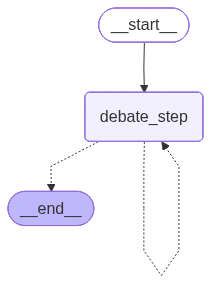

In [17]:
# testing out a smaple debate by making a temporary graph for debate

builder = StateGraph(DebateState)

builder.add_node("debate_step", generate_discussion)
builder.add_edge(START, "debate_step")
def should_continue(state):
    # stop if "Thank you!" appears OR turns exceeded
    last_message = state["messages"][-1].content.lower()

    if "thank you" in last_message:
        return END
    if len(state["messages"]) >= state["max_num_turns"]:
        return END
    return "debate_step"
builder.add_conditional_edges(
    "debate_step",
    should_continue,
    ["debate_step", END]
)

memory = MemorySaver()
graph = builder.compile(interrupt_before=[], checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [18]:
# Input
doctor1=doctors[0]
doctor2=doctors[1]
doctor3=doctors[2]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "2"}}
initial_state = {
    "messages": [
        {"role": "user", "content": "The patient has pleuritic chest pain and cough."}
    ],
    "doctors": doctors,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}


for event in graph.stream(initial_state, thread, stream_mode="values"):
    if "messages" in event:
        print("\n----------------------------------------------")
        print(event["messages"][-1].content)


----------------------------------------------
The patient has pleuritic chest pain and cough.

----------------------------------------------
I’m Dr. Miguel Alvarez, emergency medicine. Given pleuritic chest pain plus cough, I’m thinking immediately about pneumonia, pulmonary embolism (PE), pneumothorax, viral pleuritis, and less commonly pericarditis or rib injury. My job is to stabilize, risk-stratify, and order targeted tests without delaying time-sensitive treatments.

My opening move in the ED:
- Triage red flags and vitals: SpO2, respiratory rate, heart rate, BP, fever, mental status. Any hypotension, hypoxia, or severe distress moves this to resuscitation bay.
- At the bedside in the first 10 minutes:
  - Continuous pulse ox, IV access, ECG within 10 minutes, portable chest X-ray.
  - Focused lung ultrasound (LUS): look for lung sliding (pneumothorax), B-lines/consolidation (pneumonia), pleural effusion, and pleural line irregularity.
- Parallel labs:
  - CBC, BMP, high-sensit

In [19]:
# integration of web search

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

TAVILY_API_KEY:  ········


In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

C:\Users\hp\AppData\Local\Temp\ipykernel_20148\3381304624.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [21]:
from langchain_community.document_loaders import WikipediaLoader

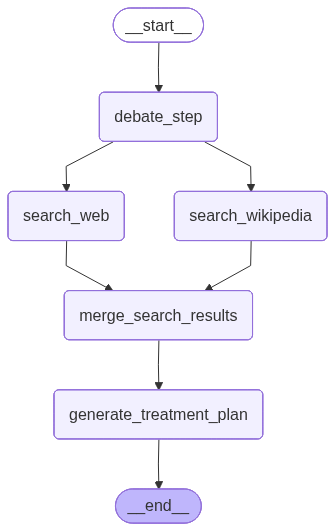

In [22]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content=f"""You will be given a conversation between medical experts diagnosing a symptom. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the treatment plan posed by each doctor.

Verify this final plan using a well-structured web search query""")

def search_web(state: DebateState):

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])

    search_docs = tavily_search.invoke(search_query.search_query)

    if isinstance(search_docs, dict) and "results" in search_docs:
        search_docs = search_docs["results"]

    formatted = []

    for doc in search_docs:
        if isinstance(doc, dict):
            url = doc.get("url", "unknown")
            content = doc.get("content", str(doc))
            formatted.append(
                f'<Document href="{url}">\n{content}\n</Document>'
            )
        else:
            formatted.append(
                f'<Document>\n{str(doc)}\n</Document>'
            )

    return {"context": ["\n\n---\n\n".join(formatted)]}


def search_wikipedia(state: DebateState):
    
    """ Retrieve docs from wikipedia """

    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=3).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def merge_search_results(state: DebateState):
    merged = "\n\n".join(state["context"])
    return {"context": [merged]}

def generate_treatment_plan(state: DebateState):
    """
    Node that merges:
    - all debate conversation
    - web + wikipedia search context
    and generates a final, unified medical treatment plan.
    """

    messages = state["messages"]            
    context_list = state.get("context", []) 
    debate_topic = state.get("debate", "")  
    
    context_text = "\n\n".join(context_list) if context_list else "No external context available."
    
    system_message = """You are a panel lead physician tasked with producing the *final medical treatment plan based on:

    1. The entire debate between specialists.
    2. The combined search context (clinical guidelines, web results, wikipedia summaries).
    3. The patient’s main complaint: {debate_topic}

    Your output must be:

    - Structured
    - Evidence-based
    - Reflective of the discussion points raised by all specialists
    - Clear and clinically actionable

    DO NOT repeat the debate.
    DO NOT repeat the search results.
    Synthesize everything into a **single, authoritative treatment plan**.

    Include:
    - Primary diagnosis or differential
    - Recommended diagnostic tests with justification
    - Initial treatment
    - Follow-up considerations
    - Any red flags or escalation scenarios

Finish with: “Final plan complete.”
"""

    final_response = llm.invoke([SystemMessage(content=system_message)] + messages)
    final_response.name = "treatment_plan"

    return {"messages": [final_response]}




# Add nodes and edges 
debate_builder = StateGraph(DebateState)
debate_builder.add_node("debate_step", generate_discussion)
debate_builder.add_node("search_web", search_web)
debate_builder.add_node("search_wikipedia", search_wikipedia)
debate_builder.add_node("merge_search_results", merge_search_results)
debate_builder.add_node("generate_treatment_plan", generate_treatment_plan)

# Flow
debate_builder.add_edge(START, "debate_step")
debate_builder.add_edge("debate_step", "search_web")
debate_builder.add_edge("debate_step", "search_wikipedia")
debate_builder.add_edge("search_web", "merge_search_results")
debate_builder.add_edge("search_wikipedia", "merge_search_results")
debate_builder.add_edge("merge_search_results", "generate_treatment_plan")
debate_builder.add_edge("generate_treatment_plan", END)

# debate 
memory = MemorySaver()
debate_graph = debate_builder.compile(checkpointer=memory).with_config(run_name="Conduct Debate")

# View
display(Image(debate_graph.get_graph().draw_mermaid_png()))

In [23]:
# Input
doctor1=doctors[0]
doctor2=doctors[1]
doctor3=doctors[2]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "2"}}
initial_state = {
    "messages": [
        {"role": "user", "content": "The patient has pleuritic chest pain and cough."}
    ],
    "doctors": doctors,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}


final_plan = None

for event in debate_graph.stream(initial_state, thread, stream_mode="values"):
    if "messages" in event:
        msg = event["messages"][-1]

        if getattr(msg, "name", None) == "treatment_plan":
            final_plan = msg.content

# Print only the final treatment plan
print(final_plan)


Comprehensive treatment plan for pleuritic chest pain with cough

Primary diagnosis and prioritized differential
- High-risk, must exclude early:
  - Pulmonary embolism (PE)
  - Pneumothorax (including tension)
  - Community-acquired pneumonia ± parapneumonic effusion/empyema
  - Acute pericarditis/myopericarditis
  - Acute coronary syndrome (ACS), especially if atypical
- Other considerations:
  - Viral pleurisy/bronchitis
  - Costochondritis or rib fracture
  - Exacerbation of asthma/COPD with pleuritic pain
  - Tuberculosis or malignancy-related pleural disease (if subacute/chronic features or risk factors)

Recommended diagnostic tests with justification
Immediate triage (perform in parallel):
- Vitals and pulse oximetry: identify hypoxemia, tachycardia, fever, shock.
- 12‑lead ECG within 10 minutes: screen for ACS, pericarditis patterns, and PE-related strain.
- Chest X-ray (PA/lateral when possible): evaluate for pneumonia, effusion, pneumothorax, alternative diagnoses.
- Point-o

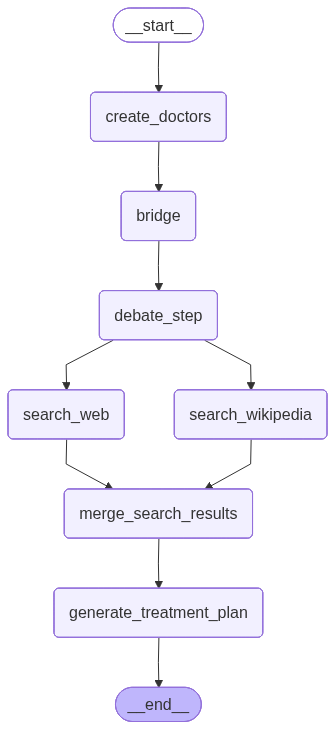

In [24]:
from dataclasses import dataclass, field
@dataclass
class FinalState:
    symptom: str 
    max_doctors: int  
    doctors: List[Doctor]
    max_num_turns: int 
    context: Annotated[list, operator.add] 
    debate: str 
    sections: list
    

def bridge(FinalState):
    return FinalState

full_builder = StateGraph(FinalState)
full_builder.add_node("create_doctors", create_doctors)
#full_builder.add_node("human_feedback", human_feedback)

full_builder.add_node("bridge",bridge)

full_builder.add_node("debate_step", generate_discussion)
full_builder.add_node("search_web", search_web)
full_builder.add_node("search_wikipedia", search_wikipedia)
full_builder.add_node("merge_search_results", merge_search_results)
full_builder.add_node("generate_treatment_plan", generate_treatment_plan)

# Flow
full_builder.add_edge(START, "create_doctors")
full_builder.add_edge("create_doctors", "bridge")
#full_builder.add_conditional_edges("human_feedback", should_continue, ["create_doctors", "bridge"])



full_builder.add_edge("bridge", "debate_step")
full_builder.add_edge("debate_step", "search_web")
full_builder.add_edge("debate_step", "search_wikipedia")
full_builder.add_edge("search_web", "merge_search_results")
full_builder.add_edge("search_wikipedia", "merge_search_results")
full_builder.add_edge("merge_search_results", "generate_treatment_plan")
full_builder.add_edge("generate_treatment_plan", END)

# debate 
memory = MemorySaver()
final_graph = full_builder.compile(checkpointer=memory).with_config(run_name="Full run")

# View
display(Image(final_graph.get_graph().draw_mermaid_png()))

In [25]:
# Input
symptom=input("Enter symptom")
max_doctors=3
doctors=[]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "5"}}
initial_state = {
    "messages": [
        {"role": "user", "content": symptom}
    ],
    "symptom": symptom,
    "max_doctors": max_doctors,
    "doctors": doctors,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}

final_plan = None
final_state = None

for event in final_graph.stream(initial_state, thread, stream_mode="values"):
    final_state = event


print(final_state.keys())
print(final_state['doctors'])
for m in final_state['messages']:
    print(m.content)
    print("\n" + "-"*50 + "\n")   # optional separator




Enter symptom I have head ache


dict_keys(['symptom', 'max_doctors', 'doctors', 'max_num_turns', 'context', 'debate', 'sections', 'messages'])
[Doctor(name='Dr. Anika Mehra, MD, FAAN', qualifications='MD (Neurology), Fellowship in Headache Medicine, FAAN', specialization='Neurologist', experience=15, description='Senior neurologist at City Neurology & Headache Center leading a multidisciplinary headache clinic. Expertise in migraine, cluster headache, and secondary headache evaluation; offers CGRP therapies, onabotulinumtoxinA for chronic migraine, and nerve blocks. Published in Cephalalgia and active member of the American Headache Society.'), Doctor(name='Dr. Samuel Ortiz, MD', qualifications='MD, Board Certified in Internal Medicine', specialization='Internal Medicine (Primary Care)', experience=12, description='Primary care physician at Downtown Internal Medicine Associates focusing on first-line headache assessment. Screens for red flags, manages tension-type headaches, coordinates imaging when indicated, and pr

In [26]:
symptom=input("Enter symptom")
max_doctors=3
doctors=[]
max_num_turns = 15
topic = "Treating the symptom"
thread = {"configurable": {"thread_id": "5"}}
initial_state = {
    "messages": [
        {"role": "user", "content": symptom}
    ],
    "symptom": symptom,
    "max_doctors": max_doctors,
    "doctors": doctors,
    "context": [],
    "max_num_turns": max_num_turns,
    "debate": topic,
    "sections": []
}

final_state = None

for event in final_graph.stream(initial_state, thread, stream_mode="values"):
    final_state = event


print(final_state.keys())
print(final_state['doctors'])
for m in final_state['messages']:
    print(m.content)
    print("\n" + "-"*50 + "\n")   # optional separator


Enter symptom I have had some pain in my knees whenever I bend it fully


dict_keys(['symptom', 'max_doctors', 'doctors', 'max_num_turns', 'context', 'debate', 'sections', 'messages'])
[Doctor(name='Dr. Maya R. Desai', qualifications='MD, FAAOS', specialization='Orthopedic Surgeon (Knee & Sports Injuries)', experience=14, description='Attending orthopaedic surgeon at Regional Joint & Sports Institute. Focuses on knee arthroscopy, meniscal and ligamentous injuries, patellofemoral pain, and early osteoarthritis. Offers image-guided injections and personalized rehab pathways. Led a multicenter study on outcomes after meniscal preservation.'), Doctor(name='Dr. Samuel P. Nguyen', qualifications='MD, CAQSM, FACSM', specialization='Sports Medicine Physician', experience=12, description='Primary Care Sports Medicine specialist at Metro Sports Medicine & Performance Clinic. Expertise in nonoperative management of knee pain, diagnostic musculoskeletal ultrasound, tendinopathies, biomechanical assessment, and return-to-activity programs. Provides PRP and viscosupplemen